## **공통 라이브러리 및 드라이브 연동**

In [76]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import matplotlib.pyplot as plt 
import math
import cv2
impath = '/content/drive/My Drive/Colab Notebooks/Image_processing/image/lena_grey.bmp' #Grey_scale image만 가능
imcpath = '/content/drive/My Drive/Colab Notebooks/Image_processing/image/lena.bmp'
lanepath = '/content/drive/My Drive/Colab Notebooks/Image_processing/image/lane.jpg'
textpath = '/content/drive/My Drive/Colab Notebooks/Image_processing/Lena_text/lena(18).bmp'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1번(Image denoising) Please implement the followings and analyze the results.**



1.   Generate the following noises, and add them to the ground-truth images







> A. Impulse noise







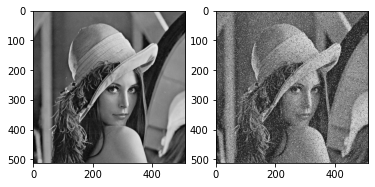

In [62]:
def impulse_noise(image,p):
    col,row = image.shape
    total = int(col*row*(p/100)) # 바꿀 픽셀 갯수
    impulse_image = image + 0
    for i in range(total//2): # 절반은 0으로
        rand = np.random.randint(0,col*row)
        c = int(rand/col)
        r = rand%col
        impulse_image[c][r] = 0
    for i in range(total//2): # 절반은 255로
        rand = np.random.randint(0,col*row)
        c = int(rand/col)
        r = rand%col
        impulse_image[c][r] = 255
    return impulse_image
image = cv2.imread(impath, cv2.IMREAD_GRAYSCALE) #image 읽기
impulse_image = impulse_noise(image,10)
plt.subplot(1,2,1)
plt.imshow(image,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(impulse_image,cmap='gray')


> B. Gaussian noise

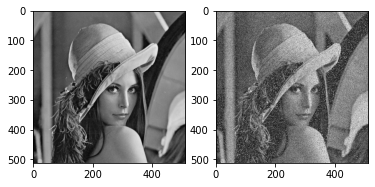

In [7]:
def gaussian_noise(image,sigma):
    col,row = image.shape
    noise = np.random.normal(0,sigma,(col,row))
    gaussian_image = image + noise
    gaussian_image = gaussian_image.astype('uint8')
    return gaussian_image
image = cv2.imread(impath, cv2.IMREAD_GRAYSCALE) #image 읽기
gaussian_image = gaussian_noise(image,30)
plt.subplot(1,2,1)
plt.imshow(image,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(gaussian_image,cmap='gray')



2.    Compute PSNR between ground-truth and noisy image



In [8]:
def PSNR(image1, image2):
    M, N = image1.shape[0],image1.shape[1]
    image1 = image1.astype('double')
    image2 = image2.astype('double')
    mse = np.mean((image1-image2)**2)
    psnr = 10 * math.log10(255**2/mse)
    return psnr
print(PSNR(image,impulse_image))
print(PSNR(image,gaussian_image))

15.628867938039352
16.50719577018445




3.    Implement the following denoising filters, and apply them for denoising



15.615159446422975


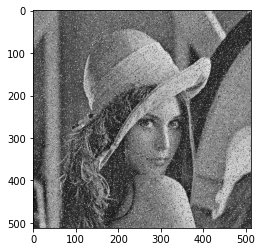

In [373]:
def gaussian_filter(k, stds):
    ran = np.arange(-k//2+1,k//2+1,1)
    rani,ranj = np.meshgrid(ran,ran)
    filter = np.exp(-(rani**2+ranj**2)//(2*stds**2))
    filter = filter/np.sum(filter)
    return filter
def filtering(image,mask):
    col,row = image.shape
    k = mask.shape[0]
    image = np.pad(image,k//2,'reflect')
    filter = np.zeros((col,row))
    for i in range(col):
        for j in range(row):
            filter[i][j] =  np.sum(image[i:i+k,j:j+k]*mask)
    filter = filter.astype('uint8')
    return filter
gfilter = gaussian_filter(5,0.1)
# plt.imshow(gfilter,cmap='gray')
gimage = filtering(impulse_image,gfilter)
plt.imshow(gimage,cmap='gray')
print(PSNR(image,gimage))

24.35205766079854


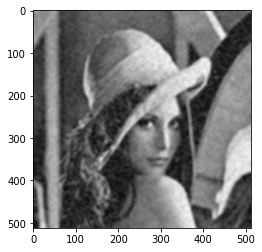

In [35]:
def bilateral_filter(image,k,stds,stdr):
    col,row = image.shape
    image = image.astype('double')
    image = np.pad(image,k//2,'reflect')
    ran = np.arange(-k//2+1,k//2+1,1)
    rani,ranj = np.meshgrid(ran,ran)
    Gs = np.exp(-(rani**2+ranj**2)//(2*stds**2))
    Gs = Gs/np.sum(Gs)
    filter = np.zeros((col,row))
    for i in range(col):
        for j in range(row):
            I = image[i:i+k,j:j+k] - image[i+(k//2),j+(k//2)]
            Gr = np.exp(-(I**2)//(2*stdr**2))
            G = Gr*Gs
            G = G / np.sum(G)
            filter[i][j] =  np.sum(image[i:i+k,j:j+k]*G)
    filter = filter.astype('uint8')
    return filter
bimage = bilateral_filter(gaussian_image,9,25,1000)
plt.imshow(bimage,cmap='gray')
print(PSNR(image,bimage))



4.    Please compare and analyze the results with subjective and objective (PSNR) measurements.






In [310]:
print(PSNR(image,gimage))
print(PSNR(image,bimage))

24.935406449769
21.9818768068328


## **2번(Image Restoration) Design a system to remove the text of the image.**

1. Detect the text in given images, and decompose them to the text and image.


2. Fill out the blank to make the image visually attractive. 

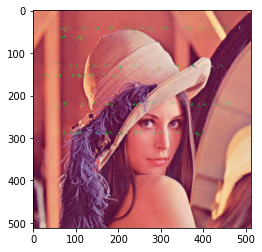

In [70]:
def dilation(binary_image):
    col,row = binary_image.shape
    S = np.array([[0,1,0],[1,1,1],[0,1,0]])
    dil = np.zeros((col,row))
    for i in range(col-1):
        for j in range(row-1):
            if binary_image[i+1,j+1] == 1:
                dil[i:i+3,j:j+3]  += binary_image[i:i+3,j:j+3]+S
    dil = np.where(dil >= 1, 1, 0)
    return dil
def remove_text(image):
    col,row = image.shape[0],image.shape[1]
    mop = np.zeros((col,row))
    remove_image = image + 0
    for i in range(col):
        for j in range(row):
            if image[i][j][1] > 235:
                mop[i][j] = 1
    mop = dilation(mop)
    for i in range(col):
        for j in range(row):
            if mop[i][j] == 1:
                # remove_image[i,j,:] = 0
                if mop[i+1][j] != 1:
                    remove_image[i,j,:] = remove_image[i+1,j,:]
                elif mop[i][j+1] != 1:
                    remove_image[i,j,:] = remove_image[i,j+1,:]
                elif mop[i][j-1] != 1:
                    remove_image[i,j,:] = remove_image[i,j-1,:]
                elif mop[i-1][j] != 1: 
                    remove_image[i,j,:] = remove_image[i-1,j,:]
                else:
                    remove_image[i,j,:] = remove_image[i-1,j-1,:]
    remove_image = remove_image.astype('uint8')
    return remove_image
image = cv2.imread(textpath) #image 읽기
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
remove_image = remove_text(image)
# plt.subplot(1,2,1)
# plt.imshow(image)
# plt.subplot(1,2,2)
plt.imshow(remove_image)

3. Please compute the PSNR of restored image.

In [77]:
image = cv2.imread(imcpath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
text_image = cv2.imread(textpath)
text_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(PSNR(image,text_image))
print(PSNR(image,remove_image))

11.501310993721585
29.59536963074241


## **3번(Image Transformation) Implement the followings and analyze and compare the results.**

1. Transform the image with arbitrary angle and scale.

2. Use the nearest neighborhood (NN) and bilinear method for interpolation



> a. NN interpolation



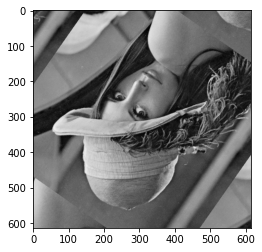

In [101]:
def scale_rotation(image, scale, angle):
    col,row = image.shape
    angle *= math.pi/180
    col_center,row_center = col//2, row//2
    S = np.array([[scale,0,0],[0,scale,0],[0,0,1]])
    R = np.array([[math.cos(angle),-math.sin(angle),0],
                   [math.sin(angle),math.cos(angle),0],
                   [0,0,1]])
    T = np.array([[1,0,col_center],[0,1,row_center],[0,0,1]])
    inverse_T = np.linalg.inv(T)
    M = np.dot(S,T)
    M = np.dot(M,R)
    M = np.dot(M,inverse_T)
    image = np.tile(image,(3,3))
    inverse_M = np.linalg.inv(M)
    col,row = round(col*scale),round(row*scale) #scale 된 image 크기
    trans_image = np.zeros((col,row))
    for i in range(col):
        for j in range(row):
            xi,yi,trash = np.dot(inverse_M,np.array([[i],[j],[1]]))
            x,y = np.trunc(xi),np.trunc(yi)
            x,y = x.astype('int'),y.astype('int')
            trans_image[i,j] = image[x,y] # NN interpolation (round 한 값을 그대로 적용)
    trans_image = trans_image.astype('uint8') #타입 변환
    return trans_image

image = cv2.imread(impath, cv2.IMREAD_GRAYSCALE) #image 읽기
trans_image = scale_rotation(image,1.2,145)
plt.imshow(trans_image,cmap='gray')

> b. Bilinear interpolation

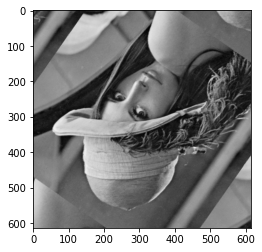

In [100]:
def scale_rotation(image, scale, angle):
    col,row = image.shape
    angle *= math.pi/180
    col_center,row_center = col//2, row//2
    S = np.array([[scale,0,0],[0,scale,0],[0,0,1]])
    R = np.array([[math.cos(angle),-math.sin(angle),0],
                   [math.sin(angle),math.cos(angle),0],
                   [0,0,1]])
    T = np.array([[1,0,col_center],[0,1,row_center],[0,0,1]])
    inverse_T = np.linalg.inv(T)
    M = np.dot(S,T)
    M = np.dot(M,R)
    M = np.dot(M,inverse_T)
    image = np.tile(image,(3,3))
    inverse_M = np.linalg.inv(M)
    col,row = round(col*scale),round(row*scale) #scale 된 image 크기
    trans_image = np.zeros((col,row))
    for i in range(col):
        for j in range(row):
            xi,yi,trash = np.dot(inverse_M,np.array([[i],[j],[1]]))
            x,y,b,a = np.trunc(xi),np.trunc(yi),xi%1,yi%1
            x,y = x.astype('int'),y.astype('int')
            # Bilinear interpolation (소수 점 값을 이용)
            trans_image[i,j] = ((1-a)*((1-b)*image[x,y]+b*image[x,y+1]))+(a*((1-b)*image[x+1,y]+b*image[x+1,y+1]))
    trans_image = trans_image.astype('uint8') #타입 변환
    return trans_image

image = cv2.imread(impath, cv2.IMREAD_GRAYSCALE) #image 읽기
trans_image = scale_rotation(image,1.2,145)
plt.imshow(trans_image,cmap='gray')

3. Compare the interpolation results. 

## **4번 (Hough Transform) Please implement the followings and analyze the results.**

1. Find the edge map using Sobel mask.


In [84]:
def sobel_gradient_dx(image):
    mx = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])   #sobel filter dx
    col, row = image.shape
    image = np.pad(image,1 ,'reflect')  #convolution을 위해 image padding
    dx = np.zeros((col,row))
    for i in range(col):
        for j in range(row):
            dx[i][j] = np.sum(image[i:i+3,j:j+3]*mx) #convolution
    return dx
def sobel_gradient_dy(image):
    my = np.array([[-1, -2, -1],[0, 0, 0],[1, 2, 1]]) #sobel filter dy
    col, row = image.shape
    image = np.pad(image,1,'reflect')  #convolution을 위해 image padding
    dy = np.zeros((col,row))
    for i in range(col):
        for j in range(row):
            dy[i][j] = np.sum(image[i:i+3,j:j+3]*my)   #convolution
    return dy
def strength(dx,dy):
    mag = np.sqrt(dx**2+dy**2) #magnitude
    return mag
def final_edge(magnitude,threshold):
    col, row = magnitude.shape
    final = np.zeros((col,row),dtype='uint8')
    for i in range(col):
        for j in range(row):
            if(magnitude[i][j]>threshold): #threshold값보다 크면 255
                final[i][j]=1
            else:                          #작으면 0
                final[i][j]=0
    return final

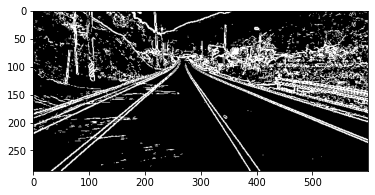

In [87]:
image = cv2.imread(lanepath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_grey = cv2.imread(lanepath, cv2.IMREAD_GRAYSCALE) #image read
dx,dy = sobel_gradient_dx(image_grey),sobel_gradient_dy(image_grey)
mag = strength(dx,dy)
final = final_edge(mag,100)
plt.imshow(image)
plt.imshow(final,cmap='gray')

2. From binary edge map, apply the Hough transform. 

3. Analyze the result in Hough domain, and find the major lines.

4. Draw the lines on top of the image as below

(array([649, 650, 651, 652, 653, 655, 657, 658, 663, 667, 673, 678, 679,
       683, 684, 685, 841, 864]), array([197, 197, 197, 196, 196, 196, 195, 195, 194, 189, 188, 187, 187,
       186, 186, 185, 125, 114]))
18
649


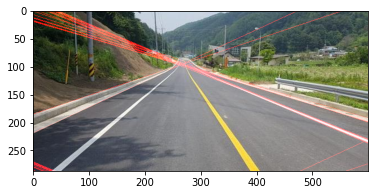

In [205]:
def hough_transform(image,image_grey):
    col,row = image_grey.shape
    theta = np.arange(0,math.pi,0.01)
    rho_max = math.sqrt(col**2+row**2)
    rho = np.arange(-rho_max,rho_max,1)
    A = np.zeros((np.size(rho),np.size(theta)))
    for j in range(col):
        for i in range(row):
            if (image_grey[j,i] == 1):
                for k in range(np.size(theta)):
                    p = j*np.sin(theta[k])+i*np.cos(theta[k])
                    rho_index = round(p-rho[0])
                    A[rho_index,k] = A[rho_index,k] + 1
    threshold = np.max(A) * 0.8
    A = np.where(A > threshold)
    max_rho = np.zeros(np.size(A[0]))
    max_theta = np.zeros(np.size(A[0]))
    for i in range(np.size(A[0])):
        max_rho[i] = rho[A[0][i]]
        max_theta[i] = theta[A[1][i]]
    for j in range(col):
        for i in range(row):
            for k in range(np.size(max_rho)):
                y = int((max_rho[k]-i*math.cos(max_theta[k]))/math.sin(max_theta[k]))
                image[y,i,0] = 255
    return image
A = hough_transform(image,final)
plt.imshow(A)